In [17]:
import pandas as pd
from utils import pca_utils, utils, pca_utils, plots
import numpy as np
from utils import plots
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

In [18]:
def del_col_max_lt_value(df, value=20):
    for c in df:
        if df[c].max() < value:
            del df[c]

def del_col_percentile_lt_value(df, value=3):
    for c in df:
        if np.percentile(df[c], 75) < value:
            del df[c]

# Abrir arquivos

In [19]:
df_pca_temas = pd.read_csv('./output/pca/df_pca_temas.csv')
df_pca_temas.set_index(df_pca_temas['id_dep'].astype(int), inplace=True, drop=True)
del df_pca_temas['id_dep']
df_pca_temas.columns = [f"temas_{c}" for c in df_pca_temas.columns]

df_pca_tipos = pd.read_csv('./output/pca/df_pca_tipos.csv')
df_pca_tipos.set_index(df_pca_tipos['id_dep'].astype(int), inplace=True, drop=True)
del df_pca_tipos['id_dep']
df_pca_tipos.columns = [f"tipos_{c}" for c in df_pca_tipos.columns]


deputados = utils.open_json("D:/ARTIGO_ABCP/data", "deputados.json")
df_deps = pd.DataFrame(deputados)
df_deps.set_index(df_deps['id'].astype(int), inplace=True)

In [20]:
# Cluster analysis

# Cluster analysis

In [21]:
def cluster_dataframe(
    df,
    techniques=["kmeans", "dbscan", "gmm"],
    k_value=3,
    eps=0.5,
    min_samples=5,
):
    """
    Clusters the input DataFrame using k-means, DBSCAN, and GMM algorithms.

    Args:
        df (pd.DataFrame): The DataFrame to be clustered.
        k_value (int, optional): Number of clusters for k-means. Defaults to 3.
        eps (float, optional): Maximum distance between two samples for DBSCAN. Defaults to 0.5.
        min_samples (int, optional): Minimum number of samples in a neighborhood for DBSCAN. Defaults to 5.

    Returns:
        pd.DataFrame: The original DataFrame with added columns for cluster labels from each algorithm.
    """

    df_c = df.copy()

    # K-means
    if "kmeans" in techniques:
        kmeans = KMeans(n_clusters=k_value, random_state=0).fit(df)
        df_c["k_means_cluster"] = kmeans.labels_

    # DBSCAN
    if "dbscan" in techniques:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
        df_c["dbscan_cluster"] = dbscan.labels_

    # Gaussian Mixture Model (GMM)
    if "gmm" in techniques:
        gmm = GaussianMixture(n_components=k_value, random_state=0).fit(df)
        df_c["gmm_cluster"] = gmm.predict(df)

    return df_c


def melt_df(df, val_columns, cluster_column="Cluster"):
    # Melt the DataFrame
    df_melted = df.reset_index().melt(
        id_vars=["id_dep", cluster_column],  # Keep these as identifier columns
        value_vars=val_columns,
        var_name="var",
        value_name="value",
    )

    df_melted["value"] = df_melted["value"].astype(float)

    return df_melted


def plot_melted_df(df_melted, hue_col="Cluster", figsize=(12, 8), xticks_rotation=45):
    # Set the desired figure size (width, height) in inches
    plt.figure(figsize=figsize)

    # Create the Seaborn boxplot
    sns.boxplot(data=df_melted, x="var", y="value", hue=hue_col)

    # Optional: Adjust layout for better readability (especially with many boxes)
    plt.xticks(rotation=xticks_rotation, ha="right")  # Rotate x-axis labels if needed

    # Show the plot
    plt.tight_layout()
    plt.show()

## Cluster temas

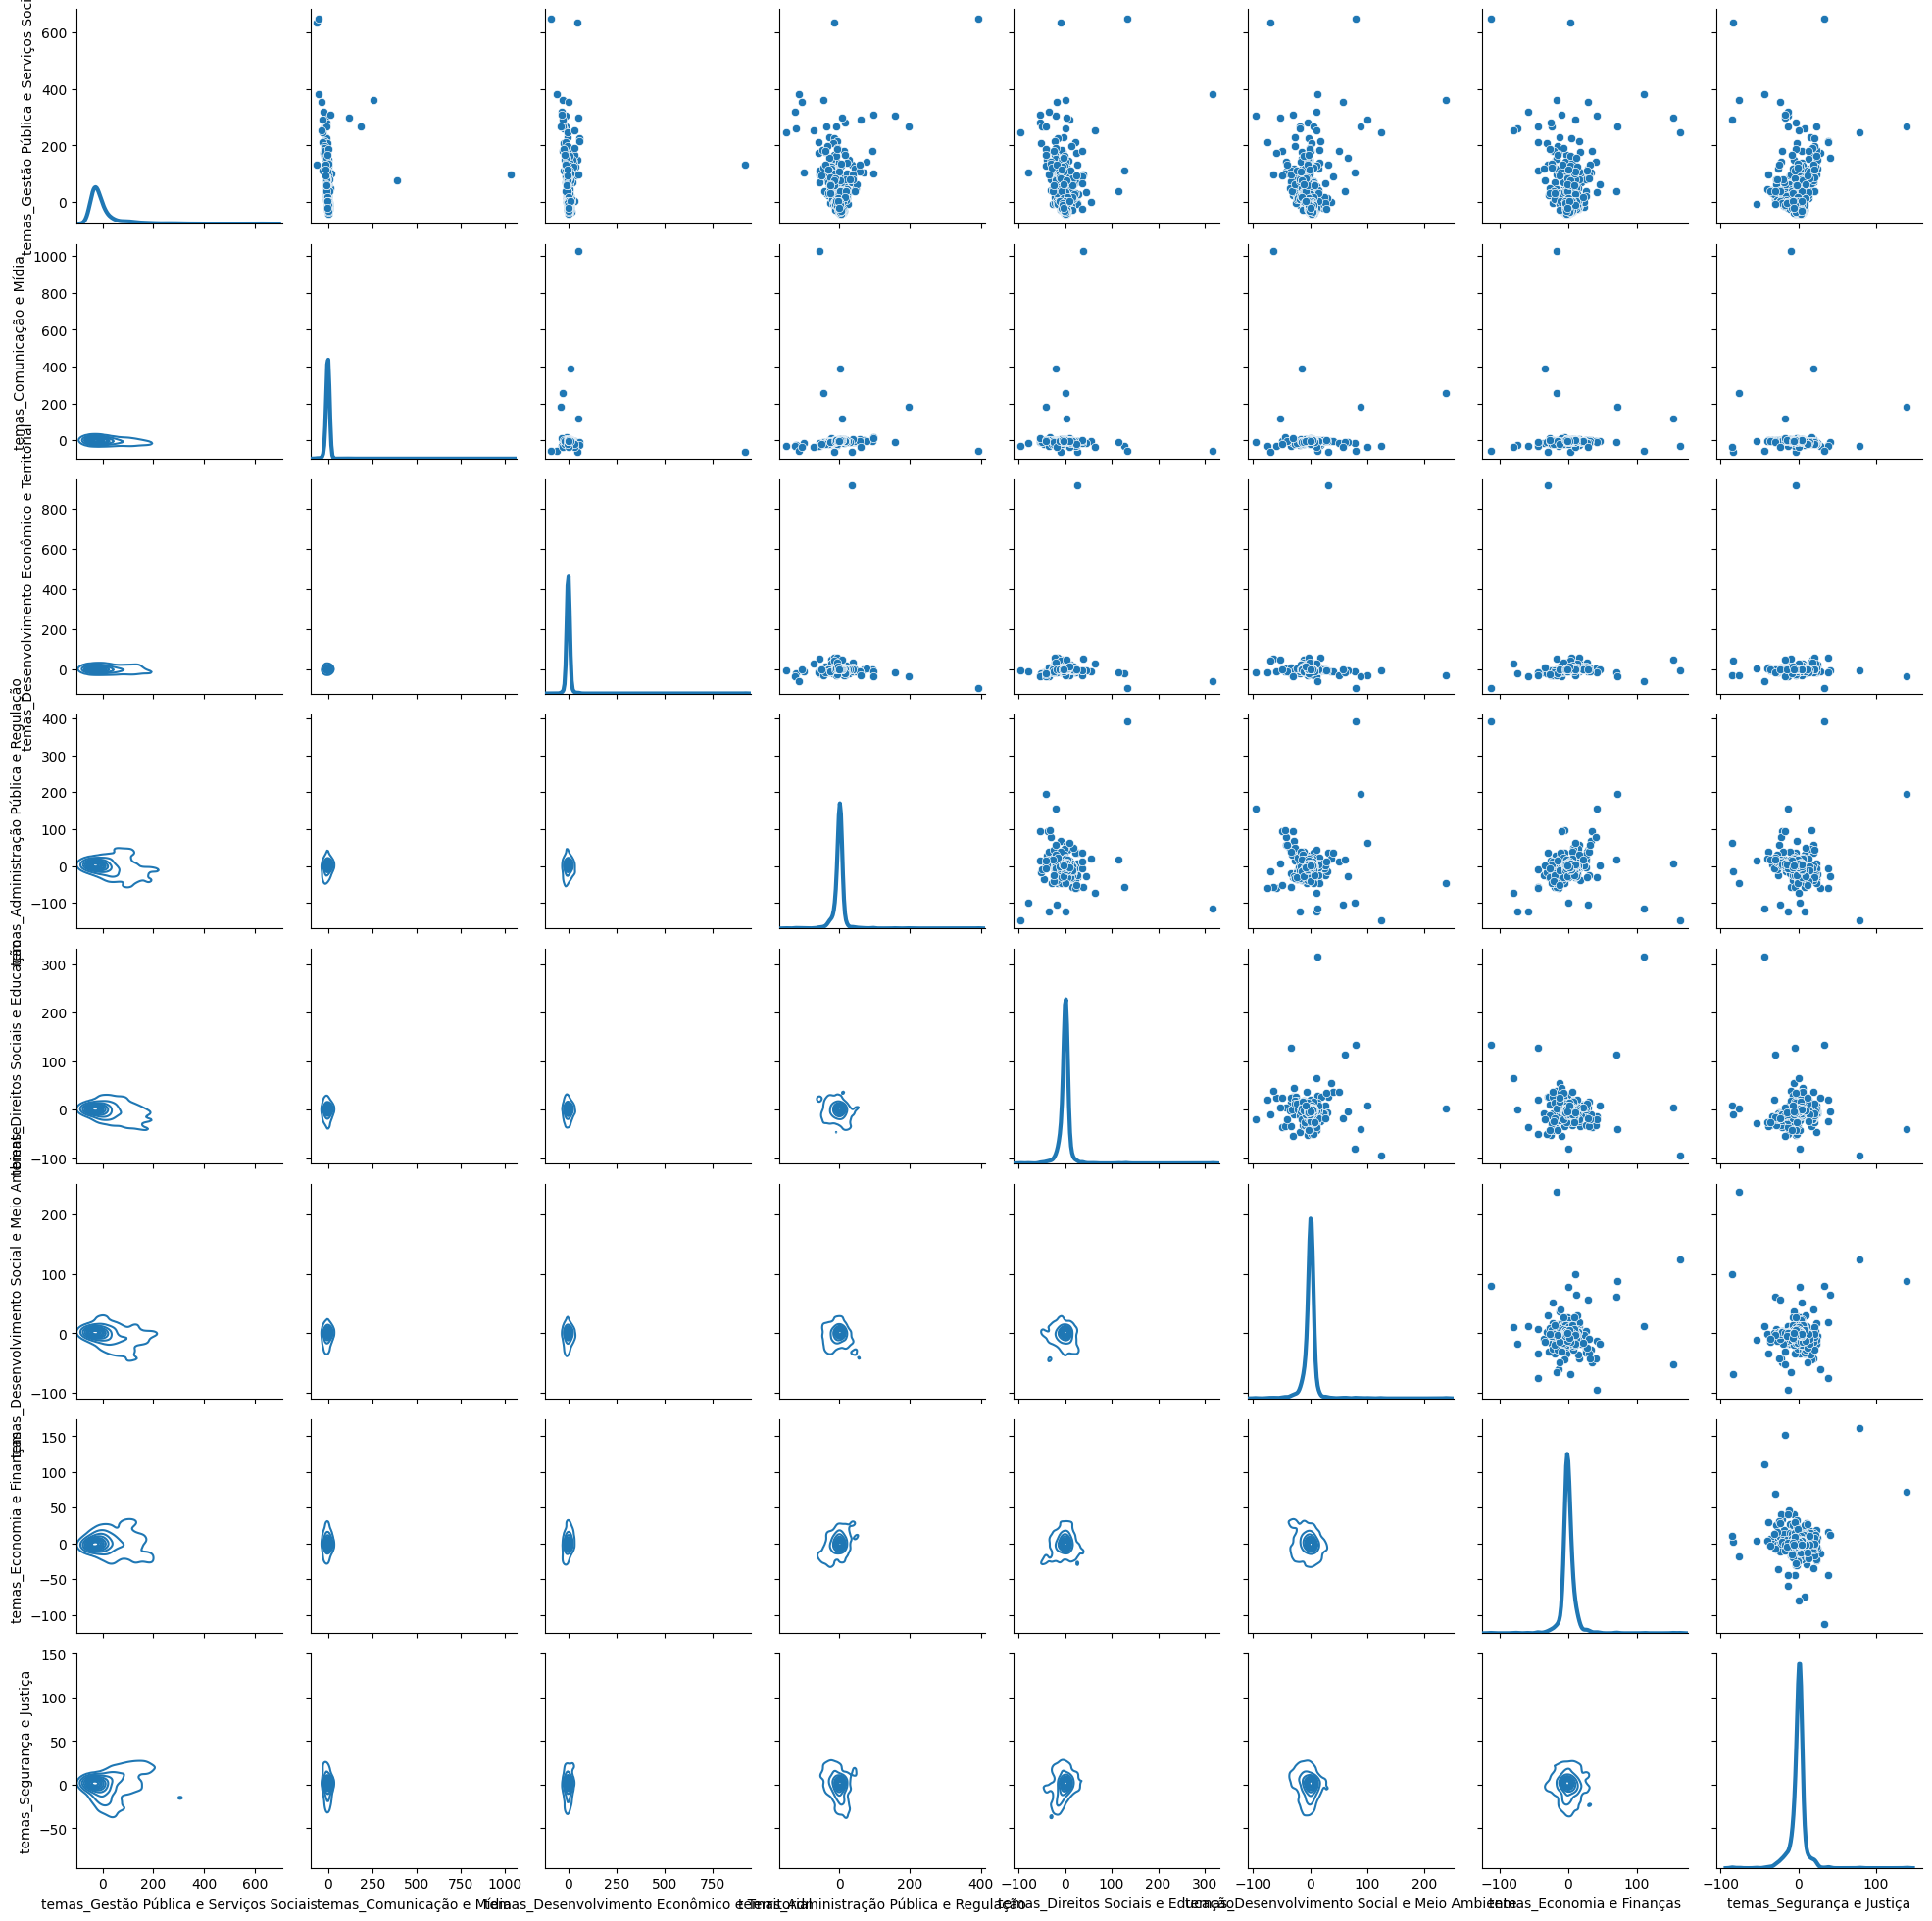

In [22]:
g = sns.PairGrid(df_pca_temas)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

Parameter: {'n_clusters': 2} Score 0.7621090464872429
Parameter: {'n_clusters': 3} Score 0.7284475031809226
Parameter: {'n_clusters': 4} Score 0.6562413597328689
Parameter: {'n_clusters': 5} Score 0.6662910218662861
Parameter: {'n_clusters': 10} Score 0.4834115509573001
Parameter: {'n_clusters': 20} Score 0.40135268811238706


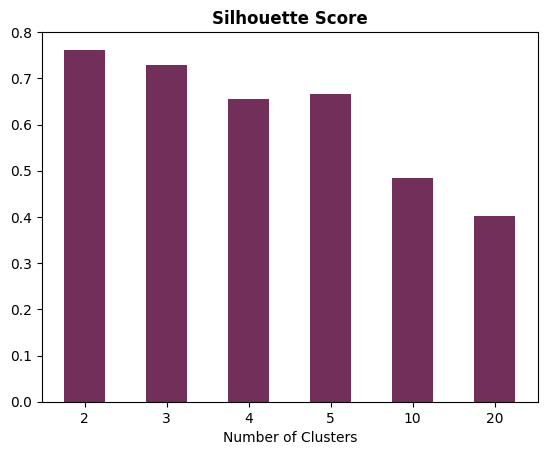

In [34]:
plots.plot_silhouette_score(df_pca_temas, parameters=[2,3,4,5,10,20])

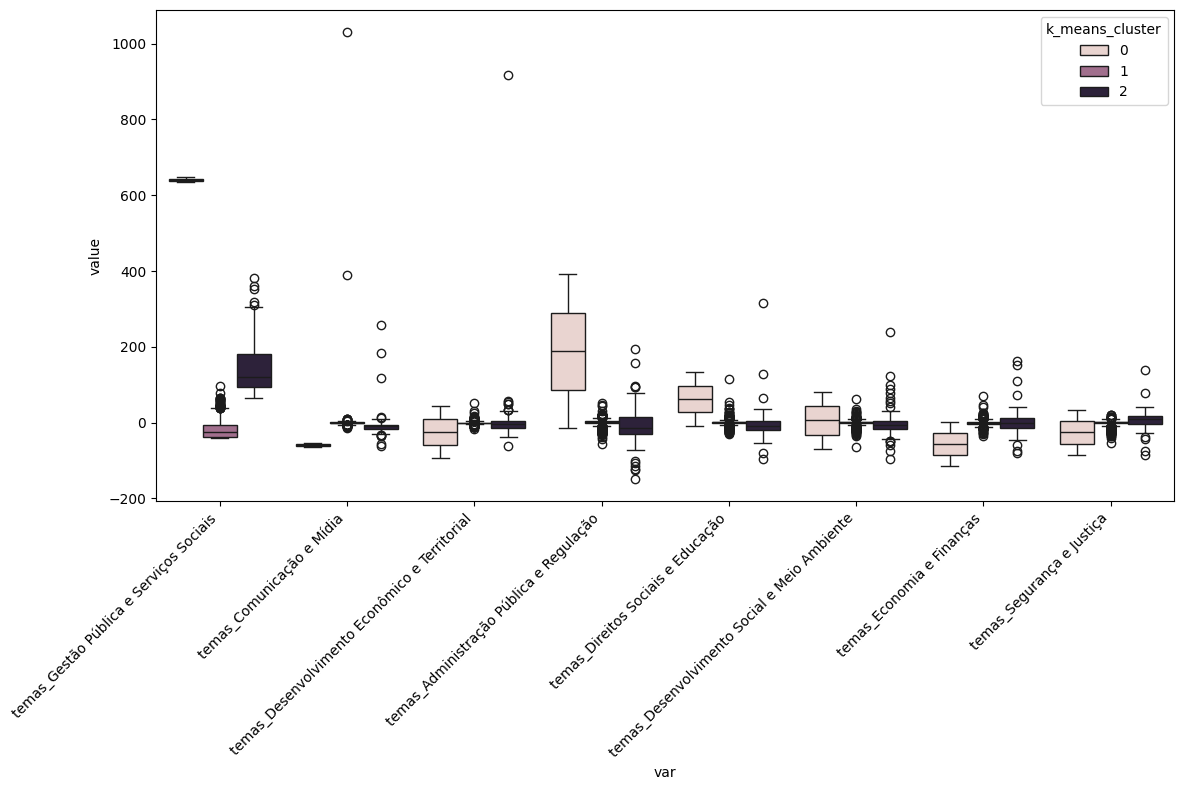

In [109]:
df_cluster_temas = cluster_dataframe(df_pca_temas, k_value=3)

cols = ["k_means_cluster"] #"gmm_cluster, "dbscan_cluster",
for col in cols:
    df_c_melted = melt_df(df_cluster_temas, val_columns=df_pca_temas.columns, cluster_column=col)
    plot_melted_df(df_c_melted, hue_col=col)

## Cluster tipos

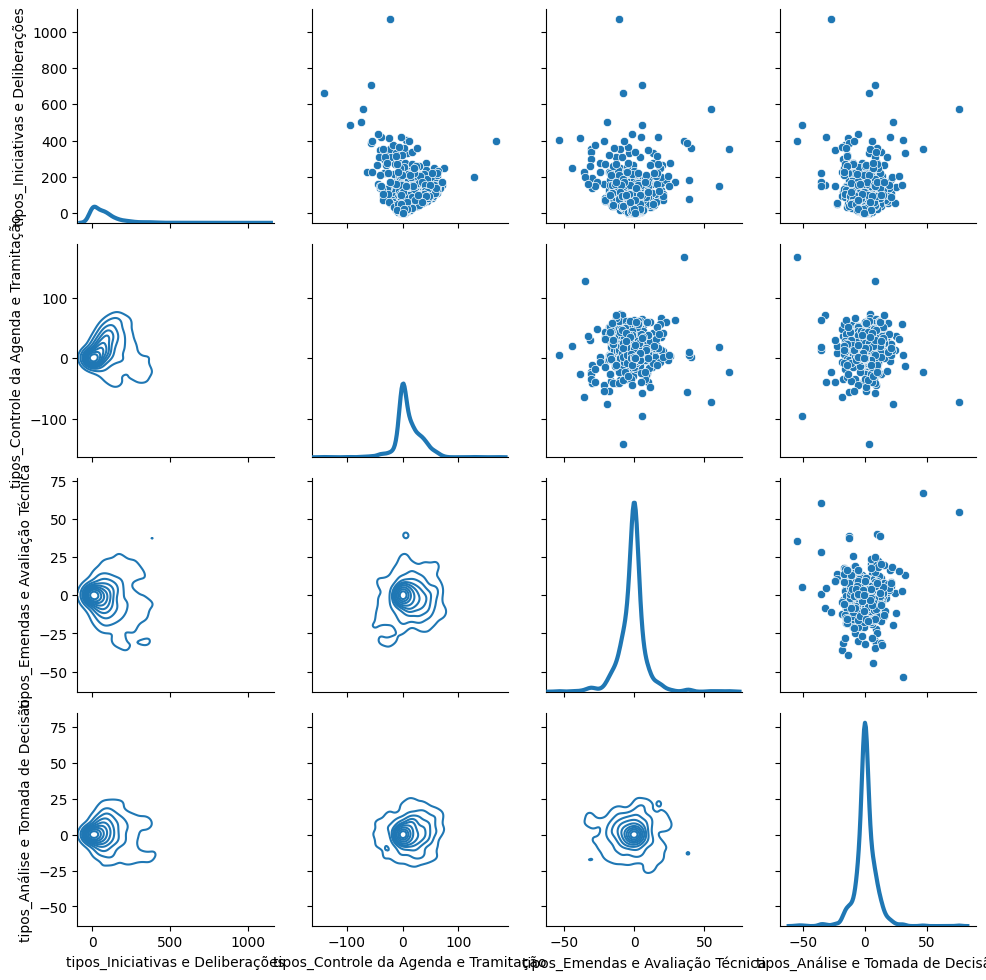

In [24]:
g = sns.PairGrid(df_pca_tipos)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

Parameter: {'n_clusters': 2} Score 0.6614779473675914
Parameter: {'n_clusters': 5} Score 0.540351253094529
Parameter: {'n_clusters': 10} Score 0.47738907917290546
Parameter: {'n_clusters': 20} Score 0.4156026406560045


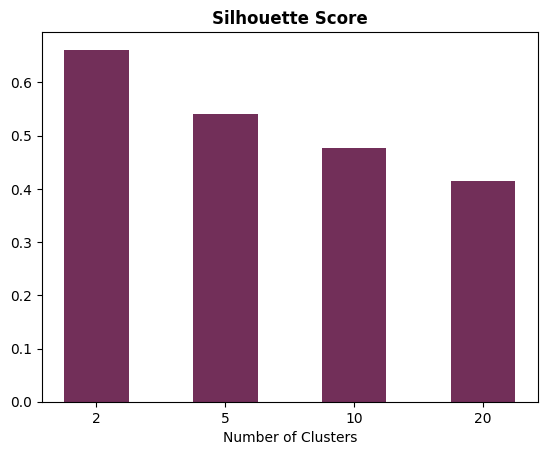

In [25]:
plots.plot_silhouette_score(df_pca_tipos, parameters=[2,5,10,20])

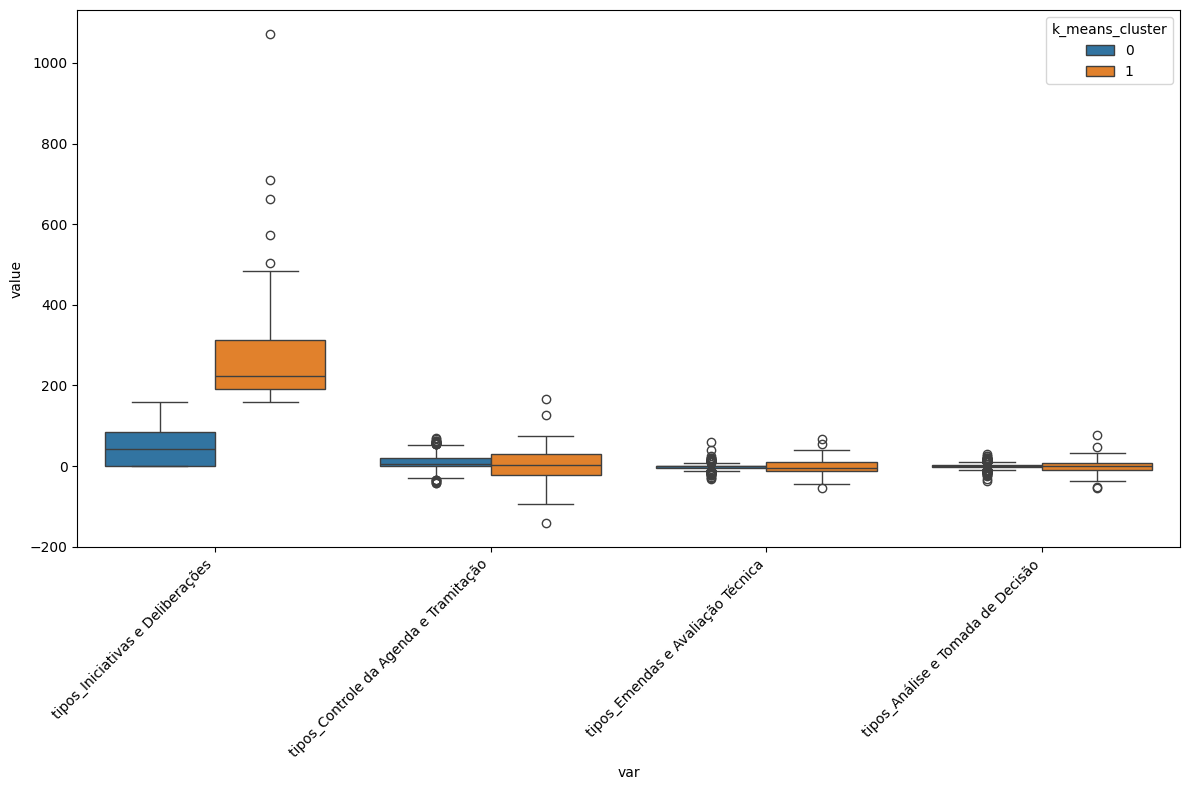

In [39]:
df_cluster_tipos = cluster_dataframe(df_pca_tipos, k_value=2)

cols = ["k_means_cluster"] #"gmm_cluster, "dbscan_cluster",
for col in cols:
    df_c_melted = melt_df(df_cluster_tipos, val_columns=df_pca_tipos.columns, cluster_column=col)
    plot_melted_df(df_c_melted, hue_col=col)

## Cluster Merge

In [27]:
df_pca_final = df_pca_tipos.join(df_pca_temas, how='inner').dropna()

Parameter: {'n_clusters': 2} Score 0.6363811567705001
Parameter: {'n_clusters': 3} Score 0.43470795493813336
Parameter: {'n_clusters': 4} Score 0.47996646505336454
Parameter: {'n_clusters': 5} Score 0.3678923297099205
Parameter: {'n_clusters': 10} Score 0.34531165618134535


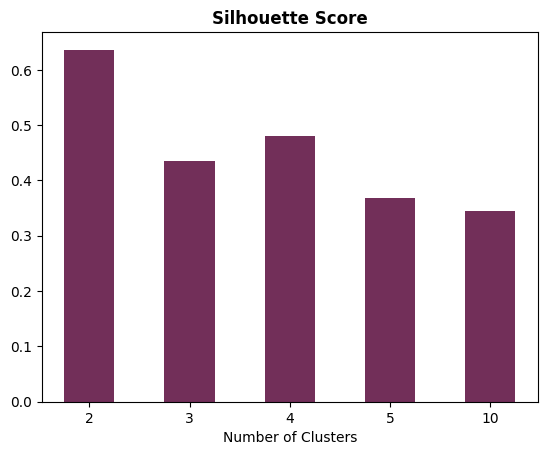

In [28]:
plots.plot_silhouette_score(df_pca_final)

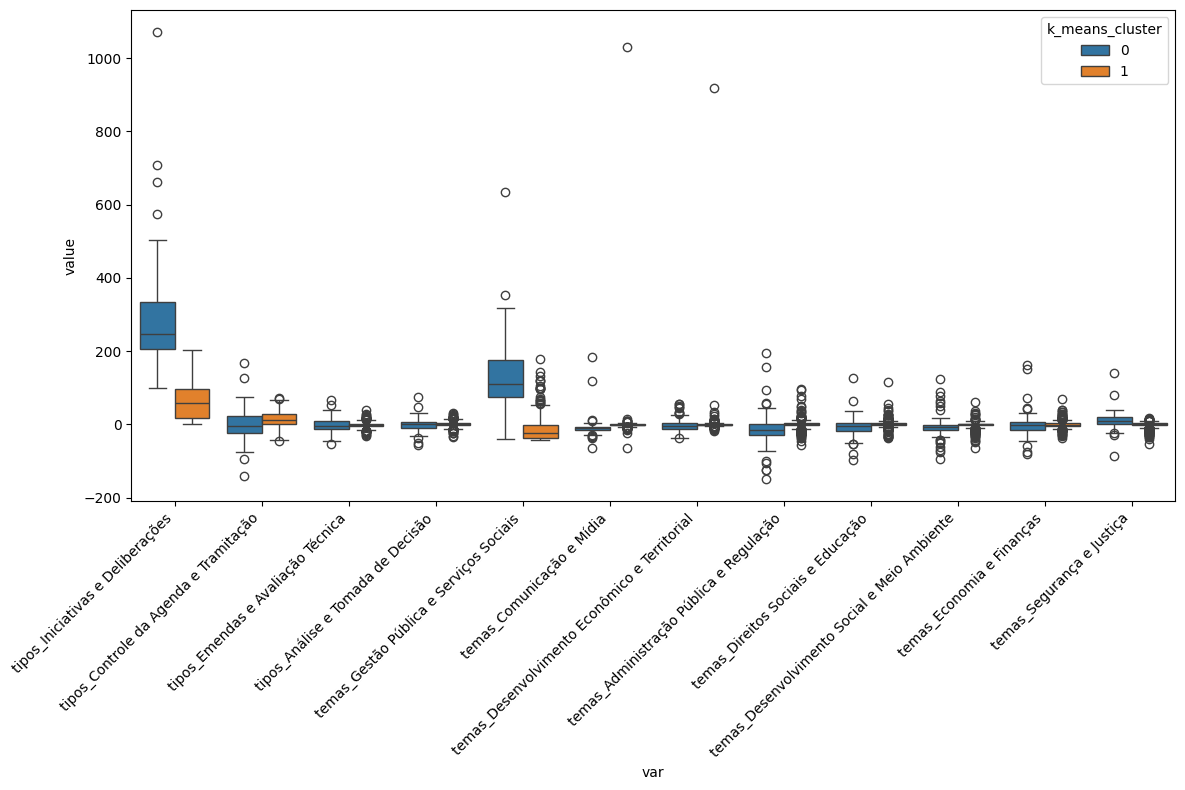

In [29]:
df_cluster = cluster_dataframe(df_pca_final, k_value=2)

cols = ["k_means_cluster"] #"gmm_cluster, "dbscan_cluster",
for col in cols:
    df_c_melted = melt_df(df_cluster, val_columns=df_pca_final.columns, cluster_column=col)
    plot_melted_df(df_c_melted, hue_col=col)

# df final (por dimensão)

In [105]:
ids_deps = df_deps["id"].unique()

df = pd.DataFrame()
df["id_dep"] = ids_deps

df = df.merge(
    df_deps[["nome", "siglaPartido", "siglaUf"]],
    how="left",
    left_on="id_dep",
    right_index=True,
).drop_duplicates("id_dep")

df.set_index('id_dep', inplace=True)


d1 = df_cluster_temas.columns[:-2]
d2 = df_cluster_tipos.columns[:-2]
df_final = df.join(df_cluster_temas[d1], how='inner').join(df_cluster_tipos[d2], how='inner', rsuffix='_tipos').dropna()

In [107]:
df_final.to_csv('./output/df_final3.csv')

In [113]:
df_final.to_excel('./output/df_final.xlsx')